In [1]:
import os
import subprocess

# For processing
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For data split
from sklearn.model_selection import train_test_split

# For Random Forest testing
import h2o

# For config parsing
import configparser
config = configparser.ConfigParser()
config.read_file(open('config/config-azure.ini'))

client_attributes_file_path = config['data-files']['clients_attributes']
active_promos_file_path = config['data-files']['active_promos']
executed_promos_file_path = config['data-files']['executed_promos']
sales_file_path = config['data-files']['sales']


In [2]:
sales = pd.read_csv(sales_file_path, encoding='latin-1')
sales

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto
0,1,2018,1,2,2.0,44,10.0,6352.94,0.03,0.0
1,1,2018,1,2,4.0,18,16.0,99130.50,0.45,0.0
2,1,2018,6,2,1.0,2,6.0,11605.40,0.07,-2880.0
3,1,2018,7,1,2.0,37,34.0,1944.01,0.01,0.0
4,1,2018,8,2,1.0,2,16.0,16250.18,0.06,0.0
...,...,...,...,...,...,...,...,...,...,...
1894247,15068,2019,8,1,2.0,44,32.0,3777.28,0.01,0.0
1894248,15069,2019,3,1,2.0,44,32.0,6295.46,0.02,0.0
1894249,15069,2019,4,1,2.0,44,32.0,6295.46,0.02,0.0
1894250,15069,2019,4,2,1.0,2,6.0,15741.56,0.08,0.0


In [3]:
executed_promos = pd.read_csv(executed_promos_file_path, encoding='latin-1')
sanitized_executed_promos = executed_promos.drop_duplicates(subset = ['Cliente', 'Marca', 'Cupo'])
sanitized_executed_promos

,CodigoDC,Cliente,Marca,Cupo
0,297601,8410,29,9
1,297601,9337,29,9
2,309843,7404,40,16
3,309874,4017,40,16
4,309910,6316,40,16
...,...,...,...,...
27763,646815,2144,29,9
27764,646976,28,29,9
27765,647188,10023,29,9
27766,648099,10193,29,9


In [4]:
active_promos = pd.read_csv(active_promos_file_path, encoding='latin-1')

In [5]:
clients_attributes = pd.read_csv(client_attributes_file_path, encoding='latin-1')
clients_attributes

,Cliente,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
0,1,2009-03-03,4,21,12,1,1,1
1,9,2009-03-03,4,21,9,2,3,1
2,15,2009-03-03,4,21,9,2,3,0
3,37,2009-03-03,4,21,16,2,3,1
4,43,2009-03-03,4,21,9,2,3,0
...,...,...,...,...,...,...,...,...
15064,15040,2019-03-07,1,16,9,2,1,0
15065,15043,2019-03-07,1,20,15,2,2,1
15066,15052,2019-03-09,3,7,10,2,2,0
15067,15065,2019-03-16,4,21,9,2,2,0


In [6]:
sales_exec_promos = sales.merge(sanitized_executed_promos, how = 'left', on = ['Cliente', 'Marca', 'Cupo'])
sales_exec_promos.loc[sales_exec_promos['CodigoDC'].isnull() == False, 'ES_PROMO'] = 'SI'

sales_exec_promos

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto,CodigoDC,ES_PROMO
0,1,2018,1,2,2.0,44,10.0,6352.94,0.03,0.0,NaN,NaN
1,1,2018,1,2,4.0,18,16.0,99130.50,0.45,0.0,NaN,NaN
2,1,2018,6,2,1.0,2,6.0,11605.40,0.07,-2880.0,NaN,NaN
3,1,2018,7,1,2.0,37,34.0,1944.01,0.01,0.0,NaN,NaN
4,1,2018,8,2,1.0,2,16.0,16250.18,0.06,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1894247,15068,2019,8,1,2.0,44,32.0,3777.28,0.01,0.0,NaN,NaN
1894248,15069,2019,3,1,2.0,44,32.0,6295.46,0.02,0.0,NaN,NaN
1894249,15069,2019,4,1,2.0,44,32.0,6295.46,0.02,0.0,NaN,NaN
1894250,15069,2019,4,2,1.0,2,6.0,15741.56,0.08,0.0,NaN,NaN


In [7]:
df = sales_exec_promos.merge(clients_attributes, how = 'left', on = 'Cliente')
final_df = df[['Cliente', 'Marca', 'Cupo', 'Region', 'Gerencia', 'SubCanal', 'TipoPoblacion', 'Estrato', 'EF','ES_PROMO']].fillna({
    'ES_PROMO': 'NO',
    'Cupo': df['Cupo'].mode()[0]
})

final_df

,Cliente,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,ES_PROMO
0,1,44,10.0,4,21,12,1,1,1,NO
1,1,18,16.0,4,21,12,1,1,1,NO
2,1,2,6.0,4,21,12,1,1,1,NO
3,1,37,34.0,4,21,12,1,1,1,NO
4,1,2,16.0,4,21,12,1,1,1,NO
...,...,...,...,...,...,...,...,...,...,...
1894247,15068,44,32.0,1,5,9,2,3,1,NO
1894248,15069,44,32.0,4,14,9,2,1,0,NO
1894249,15069,44,32.0,4,14,9,2,1,0,NO
1894250,15069,2,6.0,4,14,9,2,1,0,NO


### Preparar Data de Test y Train

In [8]:
h2o.init(nthreads = -1, max_mem_size = '16g')

df_train, df_test = train_test_split(final_df)


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 mins 03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_tjander_0b0l5m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,15.99 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


In [9]:
h2o_train = h2o.H2OFrame(df_train)
h2o_test  = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [10]:
m = h2o.estimators.H2ORandomForestEstimator(nfolds=10,
                                            max_depth=20,
                                            ntrees=50)

In [11]:
predictor_cols = ['Marca', 'Cupo', 'Region', 'Gerencia', 'SubCanal', 'TipoPoblacion', 'Estrato', 'EF']
target_col     = 'ES_PROMO'
m.train(training_frame = h2o_train,
        x = predictor_cols,
        y = target_col)

drf Model Build progress: |███████████████████████████████████████████████| 100%


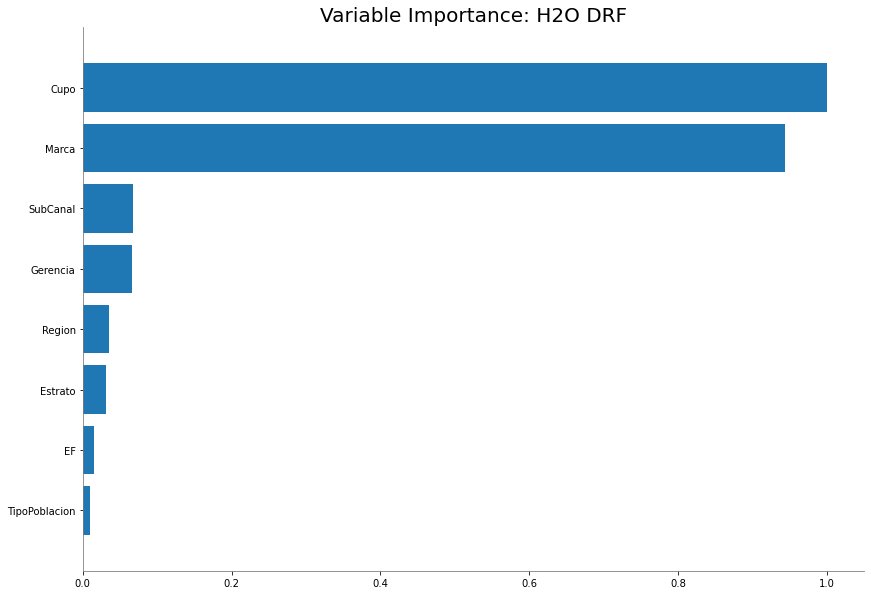

In [12]:
m.varimp_plot()

In [13]:
m.model_performance(h2o_test)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.008332448708863597
RMSE: 0.09128224750116311
LogLoss: 0.027121996647852805
Mean Per-Class Error: 0.00850232576715193
AUC: 0.9975522522991409
AUCPR: 0.9527019536363494
Gini: 0.9951045045982818

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4578921895361927: 


,,NO,SI,Error,Rate
0,NO,441514.0,4694.0,0.0105,(4694.0/446208.0)
1,SI,695.0,26660.0,0.0254,(695.0/27355.0)
2,Total,442209.0,31354.0,0.0114,(5389.0/473563.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.457892,0.908208,246.0
1,max f2,0.232209,0.954393,295.0
2,max f0point5,0.751088,0.888860,147.0
3,max accuracy,0.518971,0.988667,231.0
4,max precision,0.999428,1.000000,0.0
5,max recall,0.001654,1.000000,393.0
6,max specificity,0.999428,1.000000,0.0
7,max absolute_mcc,0.457892,0.904559,246.0
8,max min_per_class_accuracy,0.295199,0.988064,280.0
9,max mean_per_class_accuracy,0.090696,0.991498,338.0



Gains/Lift Table: Avg response rate:  5.78 %, avg score:  5.79 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010045,0.972090,17.268082,17.268082,0.997477,0.984924,0.997477,0.984924,0.173460,0.173460,1626.808228,1626.808228,0.173433
1,2,0.020086,0.939075,16.838456,17.053314,0.972660,0.956323,0.985071,0.970626,0.169073,0.342533,1583.845574,1605.331418,0.342215
2,3,0.030171,0.886601,16.101090,16.735018,0.930067,0.915041,0.966685,0.952046,0.162383,0.504917,1510.109009,1573.501755,0.503850
3,4,0.040024,0.827856,14.959492,16.297928,0.864123,0.855242,0.941437,0.928215,0.147395,0.652312,1395.949156,1529.792753,0.649825
4,5,0.050071,0.754353,14.037146,15.844284,0.810845,0.795689,0.915233,0.901623,0.141035,0.793347,1303.714641,1484.428395,0.788842
5,6,0.100105,0.003408,4.129570,9.989151,0.238541,0.251500,0.577016,0.576685,0.206617,0.999963,312.956982,898.915091,0.955025
6,7,0.150848,0.001653,0.000000,6.628950,0.000000,0.001940,0.382916,0.383350,0.000000,0.999963,-100.000000,562.895022,0.901171
7,8,0.203593,0.000256,0.000693,4.911766,0.000040,0.000838,0.283724,0.284252,0.000037,1.000000,-99.930692,391.176593,0.845231
8,9,1.000000,0.000000,0.000000,1.000000,0.000000,0.000004,0.057764,0.057875,0.000000,1.000000,-100.000000,0.000000,0.000000


In [14]:
cli_active_promo = active_promos.merge(clients_attributes, how = 'left', on = 'Cliente')
columns = final_df.columns.tolist()
index_target = columns.index('ES_PROMO')
del columns[index_target]

cli_active_promo = cli_active_promo[columns]
cli_active_promo.head(1)


h2o_predict_df = h2o.H2OFrame(cli_active_promo)

p = m.predict(h2o_predict_df)
p

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


predict,NO,SI
NO,0.809839,0.190161
NO,0.948441,0.0515588
NO,0.926198,0.0738024
SI,0.0048502,0.99515
SI,0.248752,0.751248
SI,0.0104464,0.989554
SI,0.0318993,0.968101
SI,0.043533,0.956467
SI,0.00655636,0.993444
SI,0.160483,0.839517


### Sanitizar output

In [22]:
predicted_df = h2o.as_list(p)
predicted_df = predicted_df.rename(columns = {'SI': 'Ejecuto_Promo'})

pred_merged_df = pd.concat([active_promos,predicted_df],axis=1)

# resultado_final
pred_no_dupes_df = pred_merged_df.drop_duplicates(subset = ['Cliente', 'Marca', 'Cupo'])
pred_no_dupes_df
result = pred_no_dupes_df[['Cliente', 'Marca', 'Cupo', 'Ejecuto_Promo']].set_index('Cliente')
result


,Marca,Cupo,Ejecuto_Promo
Cliente,,,
3213,29,9,0.190161
3795,29,9,0.051559
11816,29,9,0.073802
8444,40,16,0.995150
8488,40,16,0.751248
...,...,...,...
15040,39,20,0.380450
14840,40,16,0.716342
1844,29,9,0.000000


In [23]:
import tempfile
output_filename = "{}/{}".format(tempfile.gettempdir(), "bayes_random_forest.csv")

print("GUARDANDO EL OUTPUT EN {} ...".format(output_filename))
result
result.to_csv(output_filename)

GUARDANDO EL OUTPUT EN /tmp/bayes_random_forest.csv ...
